In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

datasheet = '/content/drive/My Drive/Datasheet/DDoS/dataset_sdn.csv'
df = pd.read_csv(datasheet)

Mounted at /content/drive


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104345 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           104345 non-null  int64  
 1   switch       104345 non-null  int64  
 2   src          104345 non-null  object 
 3   dst          104345 non-null  object 
 4   pktcount     104345 non-null  int64  
 5   bytecount    104345 non-null  int64  
 6   dur          104345 non-null  int64  
 7   dur_nsec     104345 non-null  int64  
 8   tot_dur      104345 non-null  float64
 9   flows        104345 non-null  int64  
 10  packetins    104345 non-null  int64  
 11  pktperflow   104345 non-null  int64  
 12  byteperflow  104345 non-null  int64  
 13  pktrate      104345 non-null  int64  
 14  Pairflow     104345 non-null  int64  
 15  Protocol     104345 non-null  object 
 16  port_no      104345 non-null  int64  
 17  tx_bytes     104345 non-null  int64  
 18  rx_bytes     104345 non-

**PREPROCESSING**

In [3]:
Features = [
    'dt','dur','dur_nsec','tot_dur','pktrate','Protocol','port_no','tx_kbps',
    'rx_kbps','tot_kbps'
]
df_clean = df[Features]

In [4]:
from sklearn.model_selection import train_test_split

X = df_clean
y = df['label']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.5 MB/s eta 0:00:00


In [7]:
Numeric_features = ['dt','dur','dur_nsec','tot_dur','pktrate','port_no','tx_kbps','rx_kbps','tot_kbps']
Kategorial_features = ['Protocol']

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_features = Numeric_features
num_transform = scaler

In [9]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('num', num_transform, num_features)
], remainder="passthrough")

In [10]:
# Membuat base model CatBoos
from catboost import CatBoostClassifier, Pool

modelCat = CatBoostClassifier(
    loss_function='Logloss',
    depth=6,
    learning_rate=0.1,
    random_state=42,
    verbose=0,
    eval_metric='Accuracy'
)

In [11]:
from sklearn.pipeline import Pipeline

cat_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier',modelCat)
])

**HYPERPARAMETER TUNING**

In [12]:
from scipy.stats import randint, uniform

param_distri = {
    # Kedalaman Pohon
    'classifier__depth':randint(4,11),
    # Learning Rate
    'classifier__learning_rate': uniform(0.01, 0.29),
    # L2 regularization di antara 1-10
    'classifier__l2_leaf_reg': randint(1,10),
    # Jumlah estimator pohon
    'classifier__n_estimators': randint(100,400),
    # Subsample rate
    'classifier__subsample': uniform(0.5,0.5),
}

In [13]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator = cat_pipeline,
    param_distributions = param_distri,
    n_iter = 15,
    cv = 5,
    scoring = 'accuracy',
    verbose = 2,
    random_state=42,
    n_jobs=-1

)

In [14]:
# Memberitahu model CatBoost kolom kategorial dari pipeline [fitur hasil scaling numerik] + [fitur yang dipassthrough]
cat_feature_indices = [len(Numeric_features)]  # kalau cuma 1 kolom kategori

In [16]:
random_search.fit(X_train, y_train, classifier__cat_features=cat_feature_indices)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['dt',
                                                                                'dur',
                                                                                'dur_nsec',
                                                                                'tot_dur',
                                                                                'pktrate',
                                                                                'port_no',
                                                                                'tx_kbps',
                                                                                'rx_kbps',
                                                                                'tot_kbps'])])),
                                             ('classifier',
                                              <catboost.core.CatBoostClassifier object at 0x7bc667a83f50>)]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'c...
                                        'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bc666adccb0>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bc666add5b0>,
                                        'classifier__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bc666add7c0>},
                   random_state=42, scoring='accuracy', verbose=2)

In [17]:
print("Best params :", random_search.best_params_)
print("Best CV Score: ", random_search.best_score_)

Best params : {'classifier__depth': 10, 'classifier__l2_leaf_reg': 4, 'classifier__learning_rate': np.float64(0.28570714885887566), 'classifier__n_estimators': 206, 'classifier__subsample': np.float64(0.8898455001363846)}
Best CV Score:  0.9984786036234807


**EVALUATE MODEL**

In [18]:
best_modelCAT = random_search.best_estimator_

In [19]:
print(best_modelCAT)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['dt', 'dur', 'dur_nsec',
                                                   'tot_dur', 'pktrate',
                                                   'port_no', 'tx_kbps',
                                                   'rx_kbps', 'tot_kbps'])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7bc666c9e9c0>)])


In [20]:
# Pengujian menggunakan dataset training

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred_train = best_modelCAT.predict(X_train)
acc = accuracy_score(y_train, y_pred_train)
print(f"Akurasi model dengan data training : {acc:.4f}")

Akurasi model dengan data training : 0.9991


In [28]:
# Pengujian menggunakan dataset uji

y_predi_test = best_modelCAT.predict(X_test)
acc_test = accuracy_score(y_test, y_predi_test)
print(f"Akurasi model dengan data pengujian : {acc_test:.4f}")

Akurasi model dengan data pengujian : 0.9989


In [29]:
print(classification_report(y_test,y_predi_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12684
           1       1.00      1.00      1.00      8185

    accuracy                           1.00     20869
   macro avg       1.00      1.00      1.00     20869
weighted avg       1.00      1.00      1.00     20869



In [24]:
# Validasi akurasi dengan cross validation
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = []

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = best_modelCAT
    model.fit(X_train, y_train, classifier__cat_features=[len(Numeric_features)])
    scores.append(model.score(X_test, y_test))

print("Mean CV Accuracy:", np.mean(scores))

Mean CV Accuracy: 0.998543293880876


In [30]:
cm = confusion_matrix(y_test, y_predi_test)
print(cm)

[[12673    11]
 [   12  8173]]


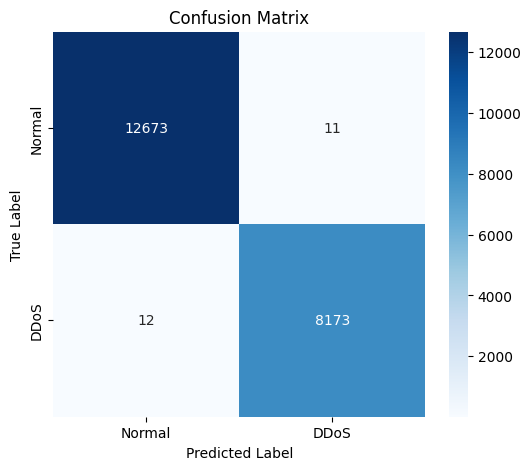

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

label = ['Normal', 'DDoS']
cm = confusion_matrix(y_test, y_predi_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap = 'Blues',
            xticklabels= label,
            yticklabels= label)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [34]:
cat_model = best_modelCAT.named_steps['classifier'] # Ambil model CATBOOST dari Pipeline
preprocessor_fit = best_modelCAT.named_steps['preprocess']


In [36]:
feature_importances = cat_model.get_feature_importance()
all_features = preprocessor_fit.get_feature_names_out()

importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(10))


               Feature  Importance
4         num__pktrate   47.106726
0              num__dt   25.960119
9  remainder__Protocol   13.731950
3         num__tot_dur    5.245014
2        num__dur_nsec    4.064537
1             num__dur    2.948166
8        num__tot_kbps    0.753034
5         num__port_no    0.112402
6         num__tx_kbps    0.057823
7         num__rx_kbps    0.020229


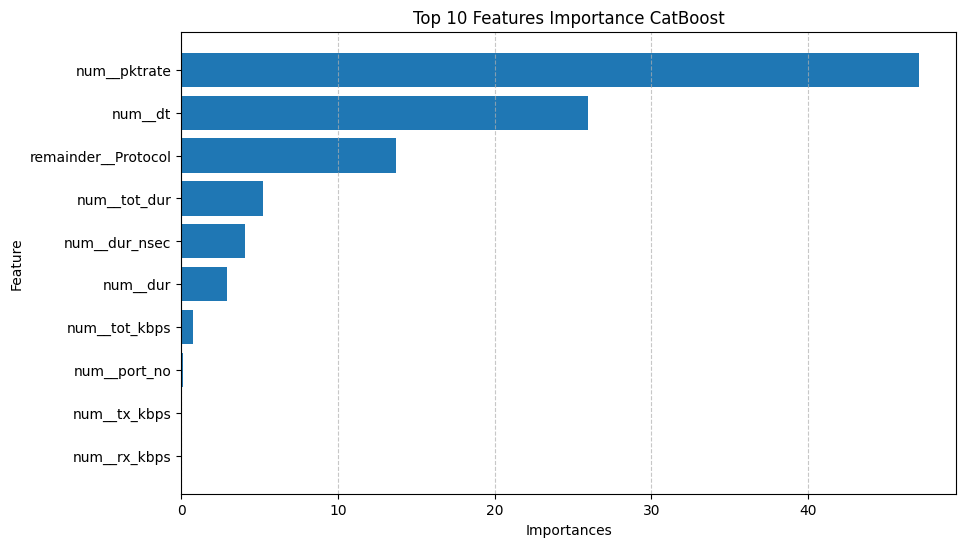

In [39]:
top_features = importance_df.head(10)

plt.figure(figsize=(10,6))
plt.barh(top_features['Feature'],top_features['Importance'])
plt.gca().invert_yaxis() # Rangking tertinggi di atas
plt.title('Top 10 Features Importance CatBoost')
plt.xlabel('Importances')
plt.ylabel('Feature')
plt.grid(axis= 'x', linestyle='--', alpha=0.7)
plt.show()

In [41]:
# Korelasi fitur
corr = df[Features + ['label']].select_dtypes(include=['number']).corr()['label'].sort_values(ascending=False)
print(corr)

label       1.000000
pktrate     0.088013
dur_nsec    0.029064
port_no    -0.004734
tx_kbps    -0.006297
rx_kbps    -0.006714
tot_kbps   -0.008748
dur        -0.098479
tot_dur    -0.098491
dt         -0.110126
Name: label, dtype: float64


In [44]:
import joblib
from google.colab import files

joblib.dump(best_modelCAT, 'DetectionDDoS_CAT.cbm')
files.download('DetectionDDoS_CAT.cbm')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>